# Flat Image Net - Evaluate Results

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from utils.data import init_dir

## Load data

In [3]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Net Graph

In [8]:
from utils.nn_graph import simple_layer
from utils.nn_visualization import variable_summaries, img_summaries

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('flat_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        keep_dropout_prob = tf.placeholder(tf.float32, name='keep_dropout_prob')

    
    with tf.variable_scope('simple_layer_1'):
        raw_prediction = simple_layer(name='layer1', input_data=images, shape=[784, 64], activation='relu')
        
    with tf.variable_scope('simple_layer_2'):
        raw_prediction = simple_layer(name='layer2', input_data=raw_prediction, shape=[64, 10])
        raw_prediction = tf.nn.dropout(raw_prediction, keep_dropout_prob)
            
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', cross_entropy_vector)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)       
        
    with tf.name_scope('training'):
        train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
            
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [10]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/flat_image_net/'

logging_meta = init_model_logging(base_dir, 'experiment_final', graph=graph, remove_existing=False)
logging_meta

{'model_path': '/tensorboard_summaries/flat_image_net/experiment_final/valid/model.ckpt',
 'saver': <tensorflow.python.training.saver.Saver at 0x7fcc4ce735c0>,
 'train_writer': <tensorflow.python.summary.writer.writer.FileWriter at 0x7fcc4be082b0>,
 'train_writer_dir': '/tensorboard_summaries/flat_image_net/experiment_final/train',
 'valid_writer': <tensorflow.python.summary.writer.writer.FileWriter at 0x7fcc4e451c88>,
 'valid_writer_dir': '/tensorboard_summaries/flat_image_net/experiment_final/valid'}

## Run Net

In [11]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']+'-4900'
        
session = tf.Session(graph=graph, config=config)
logging_meta['saver'].restore(session, model_path)
_prediction, = session.run([prediction], feed_dict={images: data.validation.images, keep_dropout_prob: 1.0})

INFO:tensorflow:Restoring parameters from /tensorboard_summaries/flat_image_net/experiment_final/valid/model.ckpt-4900


In [ ]:
session.close()

In [12]:
_prediction

array([[  3.09740874e-14,   1.65326889e-14,   5.29359678e-15, ...,
          9.88227100e-08,   4.74665995e-08,   9.99997854e-01],
       [  1.00000000e+00,   7.56196078e-11,   6.64161087e-11, ...,
          4.99924690e-15,   1.28598951e-10,   9.60757515e-12],
       [  9.18329954e-01,   6.68673888e-02,   1.58131833e-03, ...,
          1.21211218e-04,   1.64773137e-05,   1.59491119e-05],
       ..., 
       [  4.37684321e-06,   6.69319206e-07,   1.40292371e-07, ...,
          5.70603588e-04,   2.45348259e-04,   1.22794037e-04],
       [  8.62553478e-08,   2.00287582e-06,   4.87284206e-06, ...,
          3.89774907e-10,   9.98520315e-01,   9.15284723e-11],
       [  2.62139569e-04,   8.15221667e-03,   9.06418019e-04, ...,
          5.20850444e-05,   9.07763606e-05,   1.79117240e-04]], dtype=float32)

## Load reuslts to pandas df

In [13]:
from utils.results_evaluation import get_info_df

df = get_info_df(data.validation.labels, _prediction, class_id2class_name_mapping, images=data.validation.images)
df

,image,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_name_top3,predicted_class_score_top1,predicted_class_score_top3
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Ankle boot,0.999998,Ankle boot,Ankle boot,0.999998,0.999998
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0...",T-shirt/top,1.000000,T-shirt/top,T-shirt/top,1.000000,1.000000
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",T-shirt/top,0.918330,T-shirt/top,T-shirt/top,0.918330,0.918330
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129...",Dress,0.130428,T-shirt/top,Dress,0.708040,0.130428
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",T-shirt/top,0.080101,Trouser,T-shirt/top,0.909240,0.080101
5,"[0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0...",Pullover,1.000000,Pullover,Pullover,1.000000,1.000000
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sneaker,0.999923,Sneaker,Sneaker,0.999923,0.999923
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.003921...",Pullover,0.028787,Coat,Pullover,0.971212,0.028787
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,1.000000,Sandal,Sandal,1.000000,1.000000
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,1.000000,Sandal,Sandal,1.000000,1.000000


In [14]:
df.columns

Index(['image', 'label_class_name', 'label_class_score',
       'predicted_class_name_top1', 'predicted_class_name_top3',
       'predicted_class_score_top1', 'predicted_class_score_top3'],
      dtype='object')

## Recall

In [15]:
def get_recall(df, class_name):
    true_positives = len(df[(df.label_class_name==class_name) & (df.predicted_class_name_top1==class_name)])
    trues = len(df[(df.label_class_name==class_name)])
    return round(true_positives / trues * 100, 2)

In [16]:
get_recall(df, 'T-shirt/top')

90.15

## Precision

In [17]:
def get_precision(df, class_name):
    true_positives = len(df[(df.label_class_name==class_name) & (df.predicted_class_name_top1==class_name)])
    positives = len(df[(df.predicted_class_name_top1==class_name)])
    if positives == 0:
        positives = 1
    return round(true_positives / positives * 100, 2)

In [18]:
get_precision(df, 'T-shirt/top')

72.92

## Accuracy

In [19]:
def get_accuracy(df):
    return round(float(np.mean((df.label_class_name == df.predicted_class_name_top1).astype(int))) * 100, 2)

In [20]:
get_accuracy(df)

85.64

## Overall Recall and Precision

In [21]:
def get_rec_prec(df, class_id2class_name_mapping):
    return pd.DataFrame(
        {
            "class_name": [class_name for class_name in class_id2class_name_mapping.values()],
            "recall": [get_recall(df, class_name) for class_name in class_id2class_name_mapping.values()],
            "precision": [get_precision(df, class_name) for class_name in class_id2class_name_mapping.values()]
        })

In [22]:
get_rec_prec(df, class_id2class_name_mapping).sort_values(by='recall')

,class_name,precision,recall
6,Shirt,80.29,44.62
2,Pullover,77.87,74.01
3,Dress,95.63,78.64
0,T-shirt/top,72.92,90.15
4,Coat,65.09,90.16
7,Sneaker,93.70,92.97
5,Sandal,95.09,94.32
9,Ankle boot,93.76,95.06
8,Bag,91.91,97.35
1,Trouser,96.28,97.84


## False Positives

In [23]:
def get_false_positives(df, label_class_name, predicted_class_name=None):
    if predicted_class_name is None:
        condition = (df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']!=label_class_name)
    else:
        condition = (df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']==predicted_class_name)
    return df[condition].sort_values(by='predicted_class_score_top1', ascending=False)

In [24]:
fp = get_false_positives(df, 'Shirt')
fp

,image,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_name_top3,predicted_class_score_top1,predicted_class_score_top3
3087,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.207843, 0.498...",Shirt,6.450289e-10,T-shirt/top,Shirt,1.000000,6.450289e-10
4031,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,3.316402e-09,T-shirt/top,Shirt,1.000000,3.316402e-09
3946,"[0.0, 0.0, 0.00784314, 0.00392157, 0.00392157,...",Shirt,4.294994e-09,T-shirt/top,Shirt,1.000000,4.294994e-09
502,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0...",Shirt,1.467986e-09,Coat,Shirt,1.000000,1.467986e-09
523,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,1.788191e-07,T-shirt/top,Shirt,1.000000,1.788191e-07
2012,"[0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0...",Shirt,5.646267e-08,T-shirt/top,Shirt,1.000000,5.646267e-08
1388,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.313726, 0.690...",Shirt,4.192307e-07,T-shirt/top,Shirt,1.000000,4.192307e-07
3240,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,1.562545e-06,Bag,Shirt,0.999998,1.562545e-06
3530,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,1.328729e-06,Coat,Shirt,0.999998,1.328729e-06
2987,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0156863, 0.0, 0.32...",Shirt,5.607362e-09,Coat,Bag,0.999998,2.710284e-07


In [27]:
from utils.results_evaluation import plot_examples

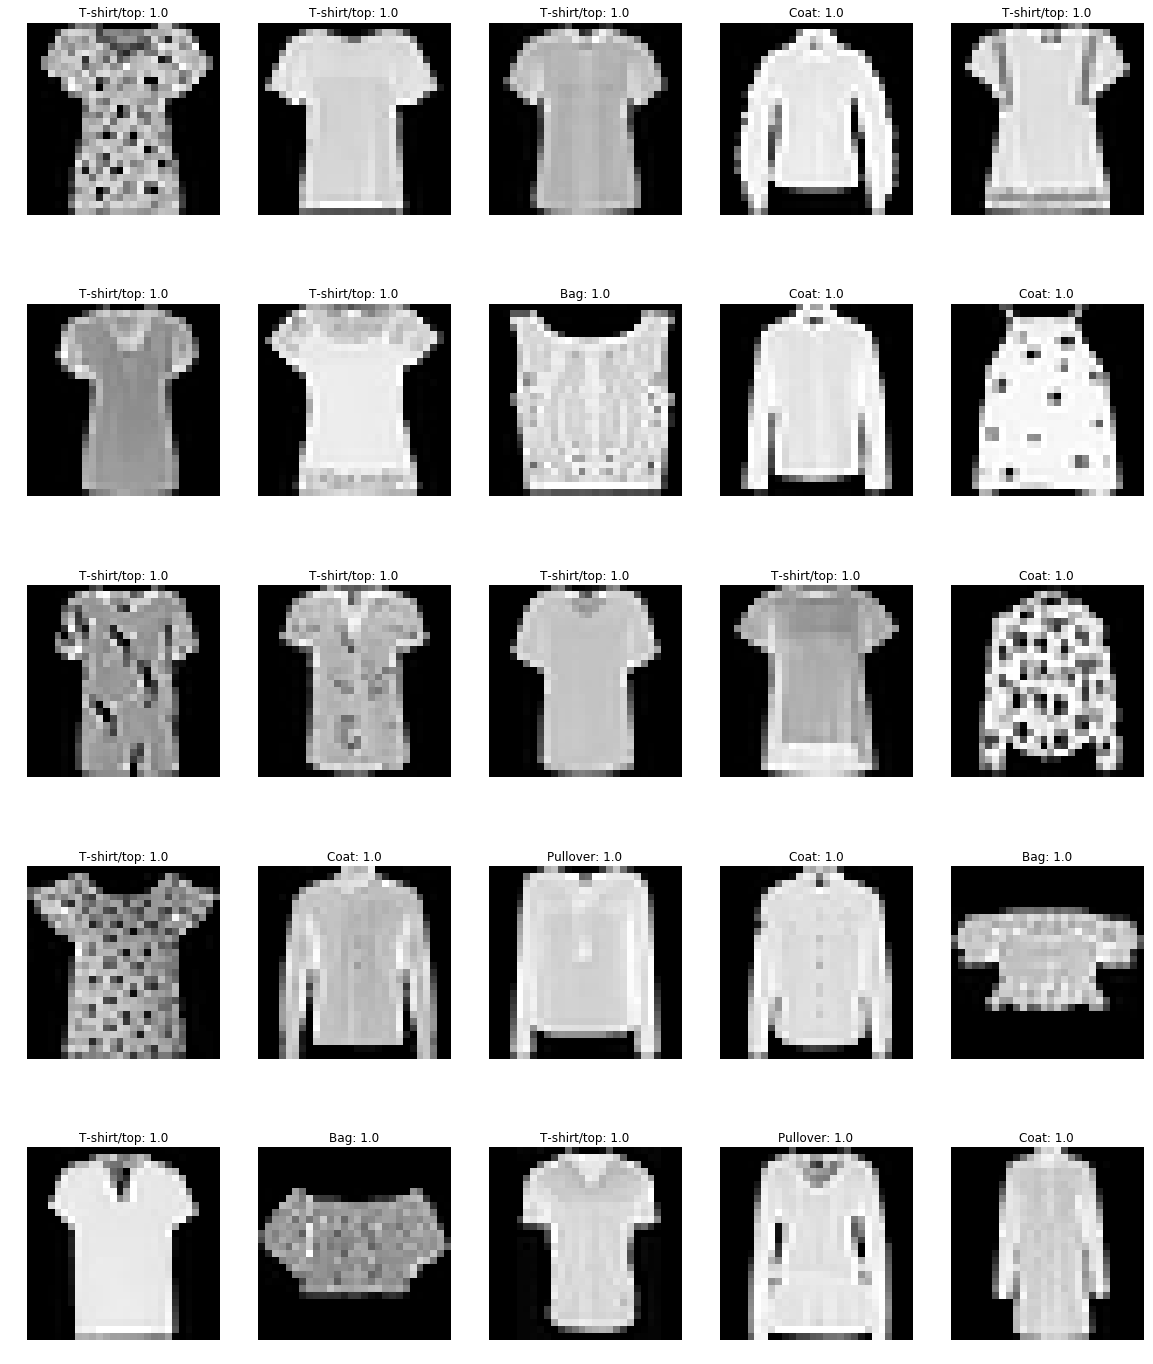

In [29]:
plot_examples(fp)

## Coocurance matrix

In [30]:
from utils.results_evaluation import plot_coocurance_matrix

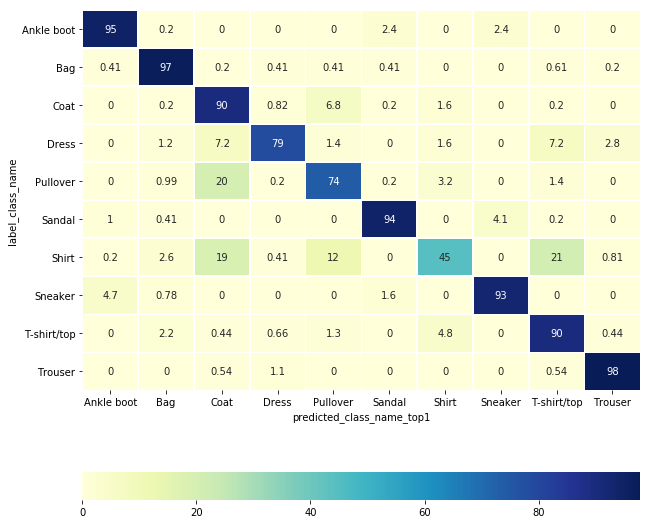

In [31]:
plot_coocurance_matrix(df, use_log=False)

/notebooks/utils/results_evaluation.py:112: RuntimeWarning: divide by zero encountered in log
  coocurance_df = np.log(coocurance_df)


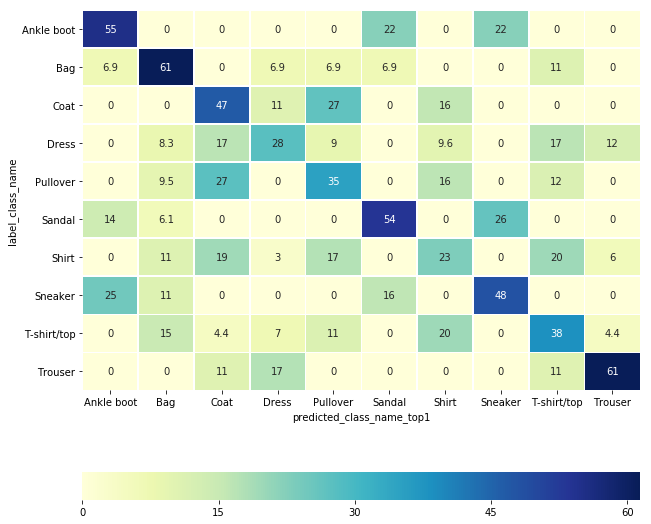

In [32]:
plot_coocurance_matrix(df, use_log=True)